Run notebook to train tf-idf based probabilistic models and contextual embeddings based probabilistc models. 

* Evaluation metric: f1-score.
* Saves best perfomring tf-idf based model and best performing contextual embedding model.
* No fine-tuning (add perhaps to automize full workflow)

In [1]:
'''basics'''
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('../..', 'src')))
sys.setrecursionlimit(20500)
import vectorize_embed as em
import make_dataset as mk
import clean_dataset as clean
import visualize as vis
import pandas as pd
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import tools as tools


'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB


'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.pipeline import Pipeline

import operator    
import joblib

import warnings
warnings.filterwarnings('ignore')

#languages
from langdetect.lang_detect_exception import LangDetectException
from langdetect import detect_langs

from google_trans_new import google_translator
translator = google_translator()  

[nltk_data] Downloading package stopwords to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Jonas
[nltk_data]     Nothnagel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Load Data

In [2]:
'''import data'''
df = pd.read_csv(os.path.abspath(os.path.join('../..', 'data/processed/encoded_labels'))+'/_hot_topics.csv')  
'''lowercase data and str type data'''
df['all_text_clean_spacy'] = df['all_text_clean_spacy'].astype(str).apply(clean.basic)
df['all_text_clean'] = df['all_text_clean'].astype(str)



<AxesSubplot:>

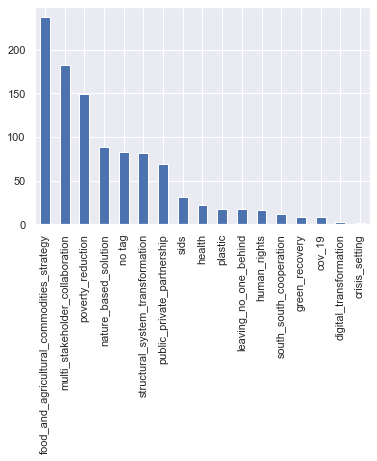

In [3]:
df[['cov_19', 'crisis_setting', 'digital_transformation',
       'food_and_agricultural_commodities_strategy', 'green_recovery',
       'health', 'human_rights', 'leaving_no_one_behind',
       'multi_stakeholder_collaboration', 'nature_based_solution', 'no tag',
       'plastic', 'poverty_reduction', 'public_private_partnership', 'sids',
       'south_south_cooperation', 'structural_system_transformation']].sum(axis=0).sort_values(ascending = False).plot.bar()

## 1. Feature Engineering tf-idf and Probabilistic Model Training

In [4]:
categories = [
       'food_and_agricultural_commodities_strategy', 'green_recovery',
       'health', 'human_rights', 'leaving_no_one_behind',
       'multi_stakeholder_collaboration', 'nature_based_solution', 'no tag',
       'plastic', 'poverty_reduction', 'public_private_partnership', 'sids',
       'south_south_cooperation', 'structural_system_transformation', 'cov_19']


remove = ['Unnamed: 4', 'crisis_setting', 'digital_transformation']

In [5]:
#Set up models

#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Logistic Regression balanced' : LogisticRegression(random_state = 3, class_weight = "balanced"),
              'Logistic Regression' : LogisticRegression(random_state = 3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Stochastic Gradient Descent balanceed' : SGDClassifier(random_state=3, loss='log',class_weight = "balanced" ),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}


#Function to get the scores for each model in a df
def model_score_df(model_dict, category):   
    
    models, model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], [], []
    
    for k,v in model_dict.items():   

        
        v.fit(X_train, y_train)
        
        model_name.append(k)
        models.append(v)
        
        y_pred = v.predict(X_test)
#         ac_score_list.append(accuracy_score(y_test, y_pred))
#         p_score_list.append(precision_score(y_test, y_pred, average='macro'))
#         r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
#         model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
#         model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#         model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)

    results = dict(zip(models, f1_score_list))
    name = dict(zip(model_name, f1_score_list))    
    #return best performing model according to f1_score
    best_clf = max(results.items(), key=operator.itemgetter(1))[0]
    best_name = max(name.items(), key=operator.itemgetter(1))[0]
    
    #save best performing model
    filename = '../../models/tf_idf/hot_topics/'+category+'_'+best_name+'_'+'model.sav'
    joblib.dump(best_clf, filename)
    
    #save best performing model without name appendix
    filename = '../../models/tf_idf/hot_topics/'+category+'_'+'model.sav'
    joblib.dump(best_clf, filename)        
    return results

In [7]:
# iterate over categories and save best models:
for category in categories: 
    
    #Creating the features (tf-idf weights) for the processed text
    texts = df['all_text_clean'].astype('str')

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                       min_df = 2, 
                                       max_df = .95)
    X = tfidf_vectorizer.fit_transform(texts)     
    y = df[category].values
        
    #save vectorizer:
    filename = '../../models/tf_idf/hot_topics/'+category+'_'+'vectorizer.sav'
    joblib.dump(tfidf_vectorizer, filename)    
    
    #Dimenionality reduction. Only using the 100 best features er category
    lsa = TruncatedSVD(n_components=100, 
                       n_iter=10, 
                       random_state=3)
    X = lsa.fit_transform(X)
    
    #save lsa model:
    filename = '../../models/tf_idf/hot_topics/'+category+'_'+'lsa.sav'
    joblib.dump(lsa, filename)
    
    #Train test split with stratified sampling for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = .3, 
                                                        shuffle = True, 
                                                        stratify = y, 
                                                        random_state = 3)
    
    model_score_df(model_dict, category)

## 3. Feature Engineering BERT, ALBERT, (DISTILBERT), GLOVE and Stochastic Gradient Classifier

In [ ]:
#Creating a dict of the embeddings
embedding_dict = {#'Glove' : 'average_word_embeddings_glove.6B.300d', 
                  #'Distilbert':'distilbert-base-nli-mean-tokens', 
                  #'Bert' : 'bert-base-nli-stsb-mean-tokens',
                  'Roberta' : 'roberta-base-nli-stsb-mean-tokens'} 

              
sdg = SGDClassifier(alpha=1e-06,
                               loss='log',
                               max_iter=1000,
                               penalty='l1',
                               random_state = 3,
                               tol=0.001)
model = OneVsRestClassifier(sdg)


#Function to get the scores for each model in a df
def model_score_context(embedding_dict, category):   
    
    models, embedding_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], [], []
    
    for k,v in embedding_dict.items():  
        
        print ('processing :' + str(k))
        embedding_name.append(k)   
        model.fit(em.get_embeddings(v, X_train), y_train)  
        
        models.append(model)
        
        y_pred = model.predict(em.get_embeddings(v, X_test))
#         ac_score_list.append(accuracy_score(y_test, y_pred))
#         p_score_list.append(precision_score(y_test, y_pred, average='macro'))
#         r_score_list.append(recall_score(y_test, y_pred, average='macro'))

        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
#         model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
#         model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#         model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    
    results = dict(zip(models, f1_score_list))
    name = dict(zip(embedding_name, f1_score_list))    
    #return best performing model according to f1_score
    best_clf = max(results.items(), key=operator.itemgetter(1))[0]
    best_name = max(name.items(), key=operator.itemgetter(1))[0]
    
    #save best performing model
    filename = '../../models/contextual_emb/hot_topics/'+category+'_'+best_name+'_'+'model.sav'
    joblib.dump(best_clf, filename)
    

    return results

In [ ]:
# iterate over categories and save best models:

for category in categories: 
    
    #Turning the labels into numbers
    y = pd.DataFrame(df_all_clean, columns = [category])

    X = df_all_clean['all_text_clean'].astype('str').tolist()

    #Train test split with stratified sampling for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = .3, 
                                                        shuffle = True, 
                                                        #stratify = y,  data is too small for stratifying
                                                        random_state = 3)
    
    results = model_score_context(embedding_dict, category)


## 4. Return top regressors based on LogReg and tf-idf

In [ ]:
df_regressors = pd.DataFrame(columns = ["label", "features", "score"])


X_train, X_test, y_train, y_test = train_test_split(df_all_clean['all_text_clean_spacy'],
                                                    df_all_clean['plastic'].values,
                                                    test_size = .3,
                                                    random_state = 1,
                                                    shuffle = True)
print('train size:', len(X_train))
print('test size:', len(X_test))

assert len(set(y_train)) == len(set(y_test)), "Unequal splits with some labels missing"

'''extract features using tfidf vecorization:'''
vectorizer = TfidfVectorizer(ngram_range = (1,2),min_df = 0.01, max_df = 0.95)


vect = vectorizer.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)




clf = LogisticRegression(penalty='l2', solver = 'lbfgs', class_weight= 'balanced').fit(X_train, y_train)
print('')
print('Training accuracy:', clf.score(X_train, y_train).round(3))
print('Test accuracy:', clf.score(X_test, y_test).round(3))
y_hat = clf.predict(X_test)
print('f1 score:', f1_score(y_test, y_hat))
#top regressors 
#return top  regressors and convert to dataframe for visualisation:
df_lambda = tools.get_topwords(clf, vectorizer, n = 8, n_models = 1, show_idxmax = True)
keywords = df_lambda.Keywords.iloc[0]

for key in keywords:

    df_regressors = df_regressors.append({'label': 'persistent_organic_pollutants', "features":key}, ignore_index=True)
    df_regressors['features'] = df_regressors['features'].astype(str)
    df_regressors['features'] = df_regressors['features'].str.replace('(','')
    df_regressors['features'] = df_regressors['features'].str.replace(')','')
    df_regressors['features'] = df_regressors['features'].str.replace("'",'')               

from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

df_regressors[['features','score']] = df_regressors['features'].str.split(',',expand=True)
df_regressors['score'] = df_regressors['score'].astype(float)    
plt.figure(figsize=(10,10))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = df_regressors)